# **1. Mounting Google Drive**

function ConnectButton(){
  console.log("Connect pushed"); 
  document.querySelector("#top-toolbar > colab-connectbutton").shadowRoot.querySelector("#connect").click() 
}
setInterval(ConnectButton,60000);

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# **2. Libraries**

In [ ]:
import os
import shutil
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
import time
import math
import seaborn as sns
import plotly.graph_objects as gp

import cv2
print(f"OpenCV Version: {cv2.__version__}")

print(f'TensorFlow Version : {tf.__version__}')
import matplotlib.pyplot as plt

OpenCV Version: 4.1.2
TensorFlow Version : 2.8.0


# **3. Data load**

Cargamos los datos, con todos los pacientes

In [ ]:
csv_folder = "/content/drive/MyDrive/TFM/Análisis/"
class_names_list = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']
df = pd.read_csv(csv_folder + "Data_Entry_2017.csv")
df

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
112115,00030801_001.png,Mass|Pneumonia,1,30801,39,M,PA,2048,2500,0.168,0.168,NaN
112116,00030802_000.png,No Finding,0,30802,29,M,PA,2048,2500,0.168,0.168,NaN
112117,00030803_000.png,No Finding,0,30803,42,F,PA,2048,2500,0.168,0.168,NaN
112118,00030804_000.png,No Finding,0,30804,30,F,PA,2048,2500,0.168,0.168,NaN


DataFrame con los enfermos

In [ ]:
df_enfermos = df[df['Finding Labels']. isin(['No Finding']) == False]

Dataframe con los sanos

In [ ]:
df_sanos = df[df['Finding Labels'].isin(['No Finding'])]

DataFrame con los pacientes solo una vez

In [ ]:
ordernados_id = df.groupby("Patient ID").first()

# 4.**Peso hombres y mujeres**

In [ ]:
df['Healthy Indicator'] = np.where(
    df['Finding Labels'] == "No Finding", 1, 0)

In [ ]:
# Diferencias entre hombres y mujeres? 
pd.crosstab(df['Patient Gender'], 
                            df['Healthy Indicator'],
                                margins = False)

Healthy Indicator,0,1
Patient Gender,,
F,22341,26439
M,29418,33922


In [ ]:
print("El odds ratio es: ", (26439*29418)/(22341*33922)) 

El odds ratio es:  1.0262994829163092


In [ ]:
from scipy import stats

data = [
    #Enfermos, Sanos
    [33922, 29418], #Mujeres
    [26439, 22341] #Hombres
]

chi2_statistic, p_value, dof, ex = stats.chi2_contingency(data)

print("Chi-squared: ", chi2_statistic)
print("p-value: ", p_value)

Chi-squared:  4.588143089352503
p-value:  0.03219387481568273


## General

In [ ]:
n_hombre,n_mujer = df['Patient Gender'].value_counts()

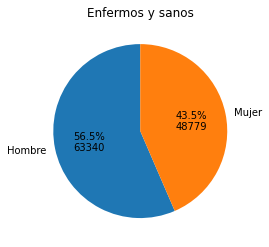

In [ ]:
# Data
y = (n_hombre, n_mujer)
labels = ['Hombre','Mujer']

# Creating autocpt arguments
def func(pct, allvalues):
    absolute = int(pct / 100.*np.sum(allvalues))
    return "{:.1f}%\n{:d}".format(pct, absolute)

# Plot
plt.pie(y, autopct = lambda pct: func(pct, y), labels = labels, startangle = 90)
plt.title('Enfermos y sanos')
plt.show()

## Enfermos

In [ ]:
n_hombre,n_mujer = df_enfermos['Patient Gender'].value_counts()

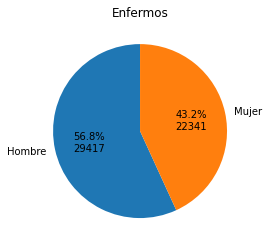

In [ ]:
# Data
y = (n_hombre, n_mujer)
labels = ['Hombre','Mujer']

# Creating autocpt arguments
def func(pct, allvalues):
    absolute = int(pct / 100.*np.sum(allvalues))
    return "{:.1f}%\n{:d}".format(pct, absolute)

# Plot
plt.pie(y, autopct = lambda pct: func(pct, y), labels = labels, startangle = 90)
plt.title('Enfermos')
plt.show()

## No Enfermos

In [ ]:
n_hombre,n_mujer = df_sanos['Patient Gender'].value_counts()

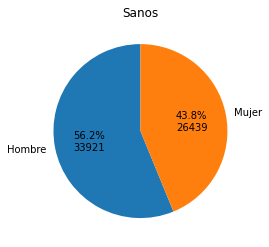

In [ ]:
# Data
y = (n_hombre, n_mujer)
labels = ['Hombre','Mujer']

# Creating autocpt arguments
def func(pct, allvalues):
    absolute = int(pct / 100.*np.sum(allvalues))
    return "{:.1f}%\n{:d}".format(pct, absolute)

# Plot
plt.pie(y, autopct = lambda pct: func(pct, y), labels = labels, startangle = 90)
plt.title('Sanos')
plt.show()

# **5. Análisis de la edad**

In [ ]:
ordernados_id['Patient Age'].describe()

count    30805.000000
mean        46.132121
std         17.013330
min          1.000000
25%         34.000000
50%         48.000000
75%         58.000000
max        412.000000
Name: Patient Age, dtype: float64

Eliminamos los valores superiores a 99 años

In [ ]:
# Cuenta de valores >99
df[df['Patient Age']>99].count()

Image Index                    16
Finding Labels                 16
Follow-up #                    16
Patient ID                     16
Patient Age                    16
Patient Gender                 16
View Position                  16
OriginalImage[Width            16
Height]                        16
OriginalImagePixelSpacing[x    16
y]                             16
Unnamed: 11                     0
Healthy Indicator              16
dtype: int64

In [ ]:
ordernados_id = ordernados_id[ordernados_id['Patient Age']<99]
ordernados_id['Patient Age'].describe()

count    30797.000000
mean        46.087768
std         16.692965
min          1.000000
25%         34.000000
50%         48.000000
75%         58.000000
max         95.000000
Name: Patient Age, dtype: float64

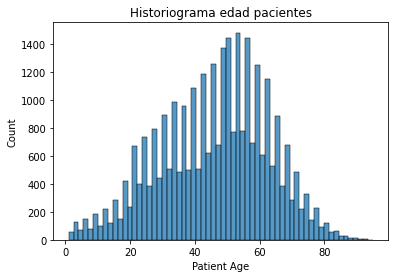

In [ ]:
sns.histplot(data=ordernados_id,
             x="Patient Age").set(title = "Historiograma edad pacientes");

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


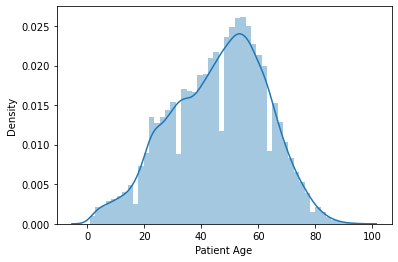

In [ ]:
sns.distplot(ordernados_id['Patient Age'])
plt.show()

Edades de enfermos Vs Edades sanos

In [ ]:
pacientes_enfermos = ordernados_id[ordernados_id['Finding Labels']. isin(['No Finding']) == False]
pacientes_sanos = ordernados_id[ordernados_id['Finding Labels'].isin(['No Finding'])]

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/dis

[Text(0, 0.5, 'y-axis'), Text(0.5, 0, 'x-axis')]

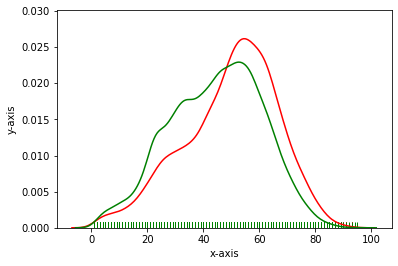

In [ ]:
ax = plt.subplots() 
  
ax = sns.distplot(pacientes_enfermos['Patient Age'], color='red', rug=True, hist=False)
ax = sns.distplot(pacientes_sanos['Patient Age'], color='green' , rug=True, hist=False)
  
ax.set(xlabel="x-axis", ylabel="y-axis")

# **6. Piramide de población**

In [ ]:
ordernados_id['Age Categories'] = np.where(
    (ordernados_id['Patient Age'] >= 0) & (ordernados_id['Patient Age'] <=9), "0 - 9", np.where(
    (ordernados_id['Patient Age'] >= 10) & (ordernados_id['Patient Age'] <=19), "10 - 19", np.where(
    (ordernados_id['Patient Age'] >= 20) & (ordernados_id['Patient Age'] <= 29), "20 - 29", np.where(
    (ordernados_id['Patient Age'] >= 30) & (ordernados_id['Patient Age'] <= 39), "30 - 39", np.where(
    (ordernados_id['Patient Age'] >= 40) & (ordernados_id['Patient Age'] <= 49), "40 - 49", np.where(
    (ordernados_id['Patient Age'] >= 50) & (ordernados_id['Patient Age'] <= 59), "50 - 59", np.where(
    (ordernados_id['Patient Age'] >= 60) & (ordernados_id['Patient Age'] <= 69), "60 - 69", np.where(
    (ordernados_id['Patient Age'] >= 70) & (ordernados_id['Patient Age'] <= 79), "70 - 79", np.where(
    (ordernados_id['Patient Age'] >= 80) & (ordernados_id['Patient Age'] <= 89), "80 - 89", np.where(
    (ordernados_id['Patient Age'] >= 90) & (ordernados_id['Patient Age'] <= 99), "90 - 99", 0))))))))))

In [ ]:
numeros = []

for i in list(range(0,101)):
  if i % 5 == 0:
    numeros.append(i)

numeros

[0,
 5,
 10,
 15,
 20,
 25,
 30,
 35,
 40,
 45,
 50,
 55,
 60,
 65,
 70,
 75,
 80,
 85,
 90,
 95,
 100]

In [ ]:
for i in numeros:
  print( '(ordernados_id["Patient Age"] >= '+ str(i) +') & (ordernados_id["Patient Age"] <='+str(i+4)+'), "' + str(i) +  ' - '+str(i+4)+'", np.where(' )

(ordernados_id["Patient Age"] >= 0) & (ordernados_id["Patient Age"] <=4), "0 - 4", np.where(
(ordernados_id["Patient Age"] >= 5) & (ordernados_id["Patient Age"] <=9), "5 - 9", np.where(
(ordernados_id["Patient Age"] >= 10) & (ordernados_id["Patient Age"] <=14), "10 - 14", np.where(
(ordernados_id["Patient Age"] >= 15) & (ordernados_id["Patient Age"] <=19), "15 - 19", np.where(
(ordernados_id["Patient Age"] >= 20) & (ordernados_id["Patient Age"] <=24), "20 - 24", np.where(
(ordernados_id["Patient Age"] >= 25) & (ordernados_id["Patient Age"] <=29), "25 - 29", np.where(
(ordernados_id["Patient Age"] >= 30) & (ordernados_id["Patient Age"] <=34), "30 - 34", np.where(
(ordernados_id["Patient Age"] >= 35) & (ordernados_id["Patient Age"] <=39), "35 - 39", np.where(
(ordernados_id["Patient Age"] >= 40) & (ordernados_id["Patient Age"] <=44), "40 - 44", np.where(
(ordernados_id["Patient Age"] >= 45) & (ordernados_id["Patient Age"] <=49), "45 - 49", np.where(
(ordernados_id["Patient Age"] >= 50) &

In [ ]:
ordernados_id['Age Categories'] = np.where(
    (ordernados_id["Patient Age"] >= 0) & (ordernados_id["Patient Age"] <=4), "00 - 4", np.where(
    (ordernados_id["Patient Age"] >= 5) & (ordernados_id["Patient Age"] <=9), "05 - 9", np.where(
    (ordernados_id["Patient Age"] >= 10) & (ordernados_id["Patient Age"] <=14), "10 - 14", np.where(
    (ordernados_id["Patient Age"] >= 15) & (ordernados_id["Patient Age"] <=19), "15 - 19", np.where(
    (ordernados_id["Patient Age"] >= 20) & (ordernados_id["Patient Age"] <=24), "20 - 24", np.where(
    (ordernados_id["Patient Age"] >= 25) & (ordernados_id["Patient Age"] <=29), "25 - 29", np.where(
    (ordernados_id["Patient Age"] >= 30) & (ordernados_id["Patient Age"] <=34), "30 - 34", np.where(
    (ordernados_id["Patient Age"] >= 35) & (ordernados_id["Patient Age"] <=39), "35 - 39", np.where(
    (ordernados_id["Patient Age"] >= 40) & (ordernados_id["Patient Age"] <=44), "40 - 44", np.where(
    (ordernados_id["Patient Age"] >= 45) & (ordernados_id["Patient Age"] <=49), "45 - 49", np.where(
    (ordernados_id["Patient Age"] >= 50) & (ordernados_id["Patient Age"] <=54), "50 - 54", np.where(
    (ordernados_id["Patient Age"] >= 55) & (ordernados_id["Patient Age"] <=59), "55 - 59", np.where(
    (ordernados_id["Patient Age"] >= 60) & (ordernados_id["Patient Age"] <=64), "60 - 64", np.where(
    (ordernados_id["Patient Age"] >= 65) & (ordernados_id["Patient Age"] <=69), "65 - 69", np.where(
    (ordernados_id["Patient Age"] >= 70) & (ordernados_id["Patient Age"] <=74), "70 - 74", np.where(
    (ordernados_id["Patient Age"] >= 75) & (ordernados_id["Patient Age"] <=79), "75 - 79", np.where(
    (ordernados_id["Patient Age"] >= 80) & (ordernados_id["Patient Age"] <=84), "80 - 84", np.where(
    (ordernados_id["Patient Age"] >= 85) & (ordernados_id["Patient Age"] <=89), "85 - 89", np.where(
    (ordernados_id["Patient Age"] >= 90) & (ordernados_id["Patient Age"] <=94), "90 - 94", np.where(
    (ordernados_id["Patient Age"] >= 95) & (ordernados_id["Patient Age"] <=99), "95 - 99",0))))))))))))))))))))

In [ ]:
age_gender = ordernados_id.groupby(['Age Categories', 'Patient Gender'])['Image Index'].count().unstack(level=-1)

In [ ]:
age_gender["M"]['95 - 99'] = 0

In [ ]:
age_gender["F_prop"] = age_gender["F"]/sum(age_gender["F"])
age_gender["M_prop"] = age_gender["M"]/sum(age_gender["M"])
age_gender

Patient Gender,F,M,F_prop,M_prop
Age Categories,,,,
00 - 4,83.0,102.0,0.005856,0.006136
05 - 9,165.0,207.0,0.011642,0.012452
10 - 14,237.0,306.0,0.016722,0.018407
15 - 19,378.0,471.0,0.026670,0.028333
20 - 24,780.0,889.0,0.055034,0.053477
25 - 29,945.0,1038.0,0.066676,0.062440
30 - 34,1138.0,1248.0,0.080294,0.075072
35 - 39,1216.0,1226.0,0.085797,0.073749
40 - 44,1452.0,1441.0,0.102448,0.086682


In [ ]:
#40-49 
print("Proportion of 40-49 year olds", (3095 + 3102) / (sum(age_gender["F"]) + sum(age_gender["M"])))

#50-59 age group 
print("Proportion of 50 - 59 year olds", (3377 + 3847) / (sum(age_gender["F"]) + sum(age_gender["M"])))

Proportion of 40-49 year olds 0.20122089813942917
Proportion of 50 - 59 year olds 0.2345683021073481


Pirámide 1

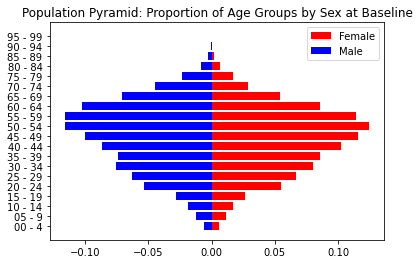

In [ ]:
# plot the proportion of age/sex 
plt.barh(age_gender.index, age_gender["F_prop"], color = 'red')
plt.barh(age_gender.index, -age_gender["M_prop"], color = 'blue')
plt.title("Population Pyramid: Proportion of Age Groups by Sex at Baseline")
plt.legend(["Female", "Male"])
plt.show()

Pirámide 2

In [ ]:
# Creating instance of the figure
fig = gp.Figure()
  
# Adding Male data to the figure
fig.add_trace(gp.Bar(y= age_gender.index, x = -age_gender["M_prop"], 
                     name = 'Male', 
                     orientation = 'h'))
  
# Adding Female data to the figure
fig.add_trace(gp.Bar(y = age_gender.index, x = age_gender["F_prop"],
                     name = 'Female', orientation = 'h'))
  
# Updating the layout for our graph
fig.update_layout(title = 'Pirámide población',
                 title_font_size = 22, barmode = 'relative',
                 bargap = 0.0, bargroupgap = 0,
                 xaxis = dict(tickvals = [-60000000, -40000000, -20000000,
                                          0, 20000000, 40000000, 60000000],
                                
                              ticktext = ['6M', '4M', '2M', '0', 
                                          '2M', '4M', '6M'],
                                
                              title = 'Population in units',
                              title_font_size = 14)
                 )
  
fig.show()

# **7. Historigrama para cada enfermedad**

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



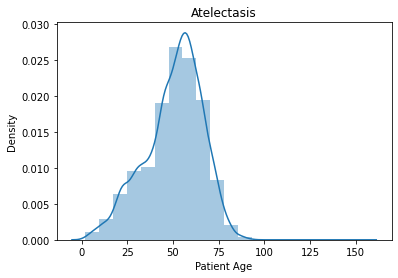

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



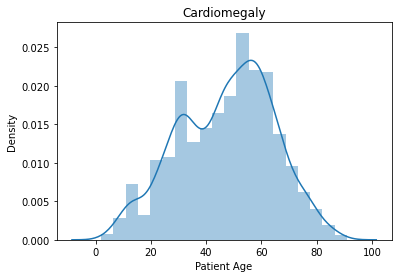

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



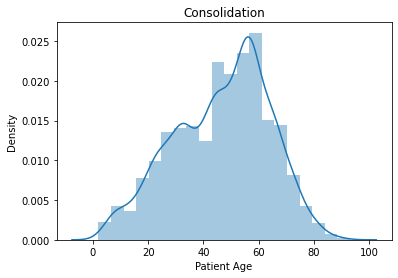

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



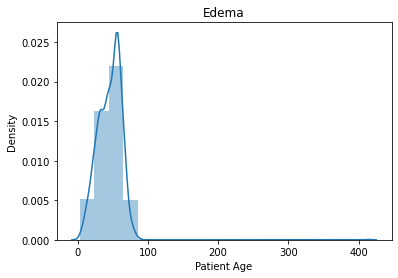

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



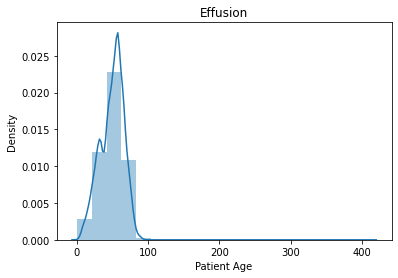

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



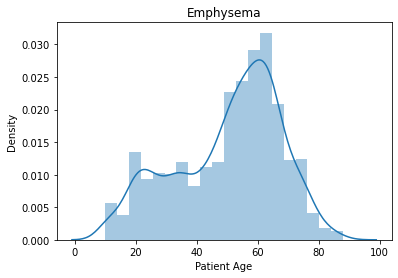

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



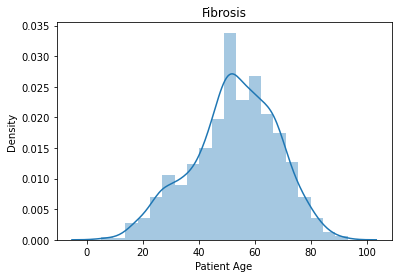

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



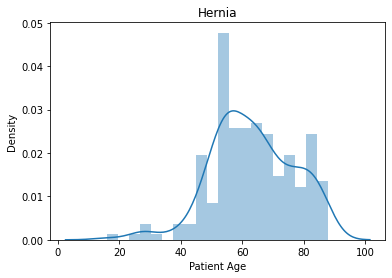

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



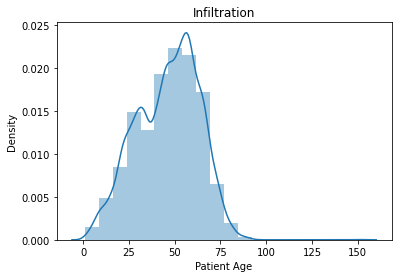

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



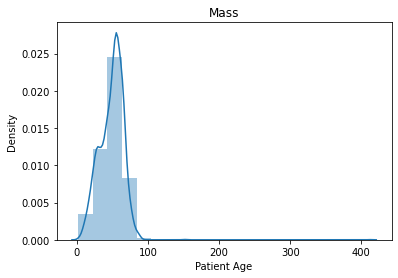

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



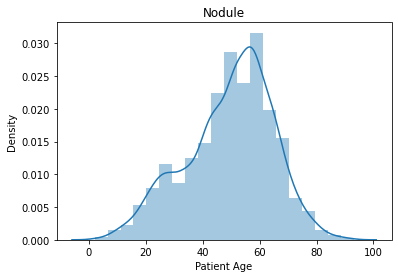

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



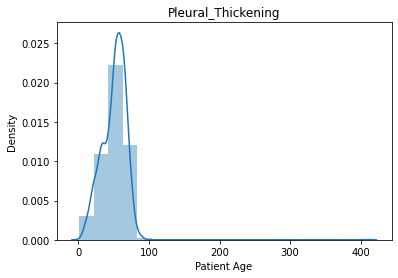

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



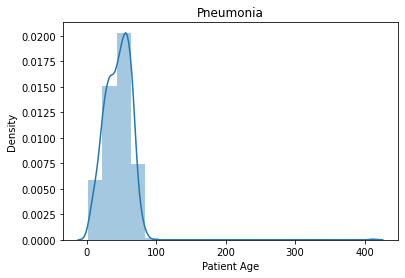

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



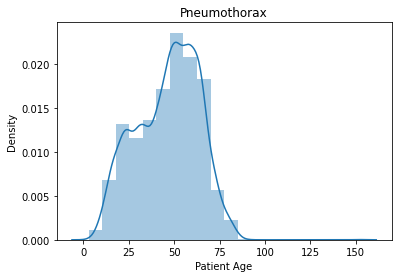

<Figure size 432x288 with 0 Axes>

In [ ]:
for name in class_names_list:
  sns.distplot(df[df['Finding Labels'].str.contains(name)]['Patient Age'], bins=20)
  plt.title(name)
  # Show and clean up plot
  plt.show()
  plt.clf()



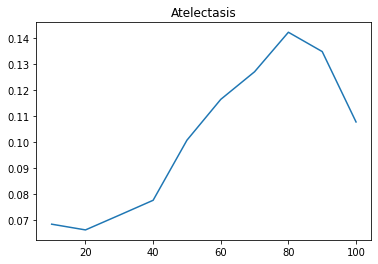

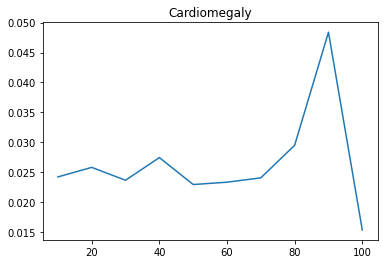

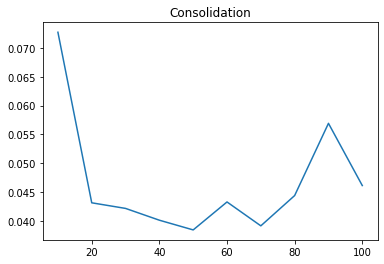

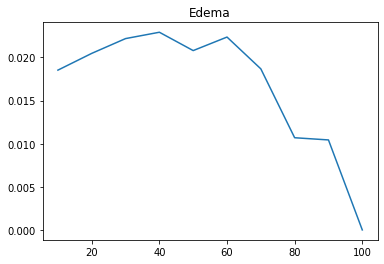

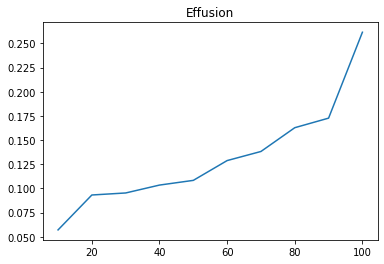

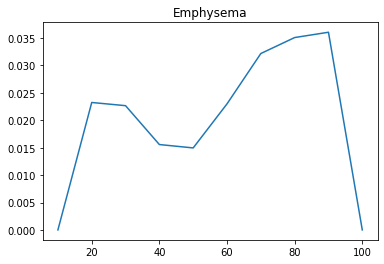

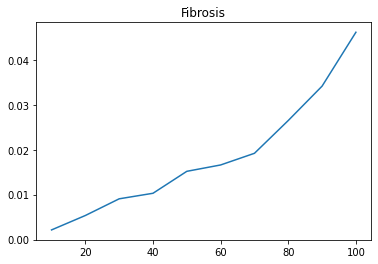

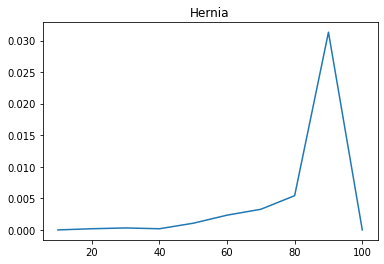

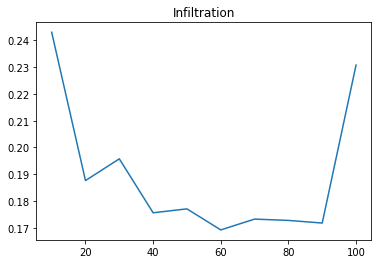

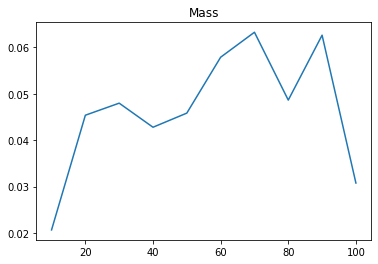

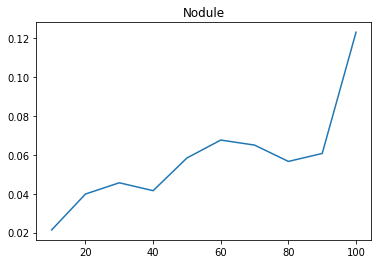

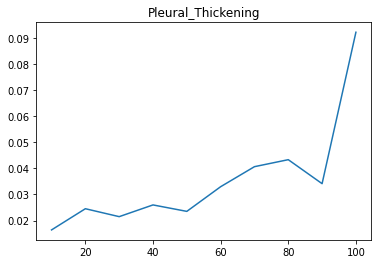

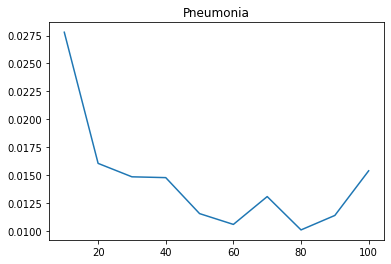

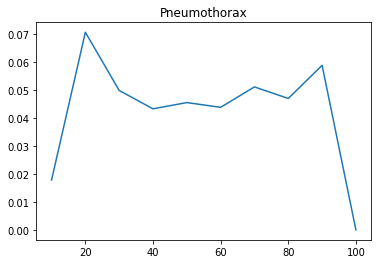

<Figure size 432x288 with 0 Axes>

In [ ]:
rangos = [10,20,30,40,50,60,70,80,90,100]

for name in class_names_list:
  porcentajes_edad = []
  j = 0
  df_inf = df[df['Finding Labels'].str.contains(name)]
  
  for i in rangos:
    num_total = df[(df['Patient Age']>=i-10) & (df['Patient Age']<i)].count()['Patient Age']
    num_caso = df_inf[(df_inf['Patient Age']>=i-10) & (df_inf['Patient Age']<i)].count()['Patient Age']
    porcentajes_edad.append(num_caso/num_total)
    j += 1
 
  plt.plot(rangos,porcentajes_edad)
  plt.title(name)
  # Show and clean up plot
  plt.show()
  plt.clf()



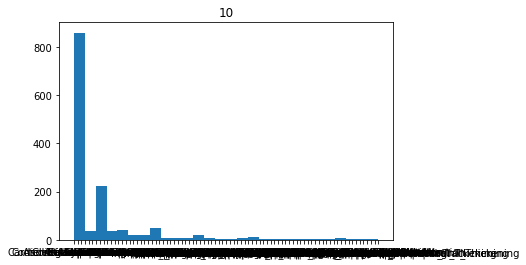

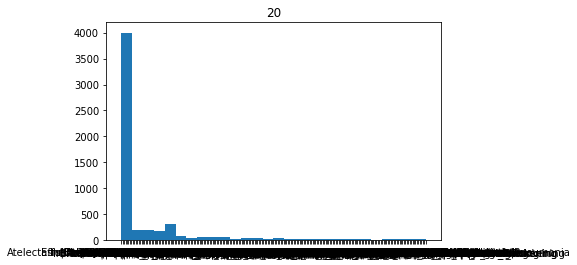

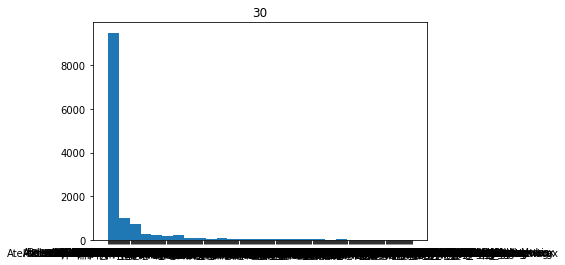

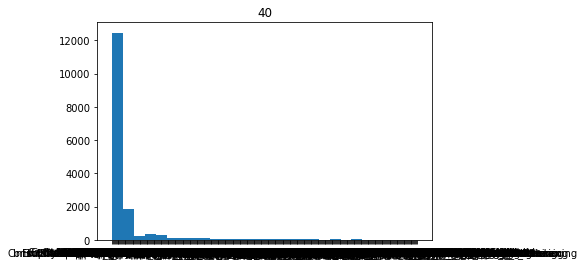

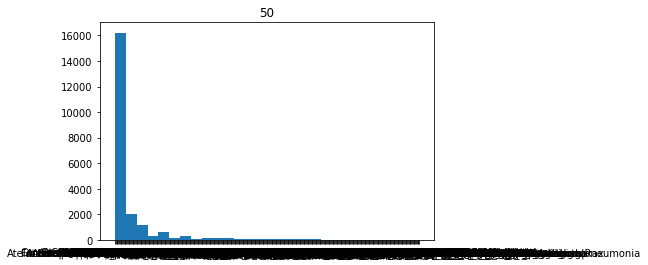

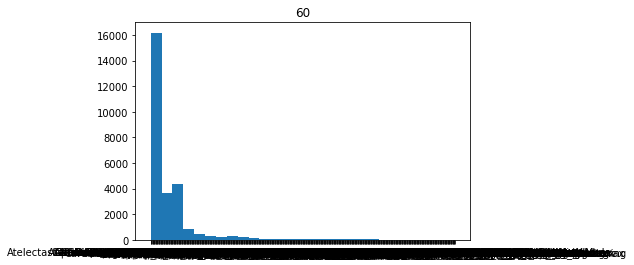

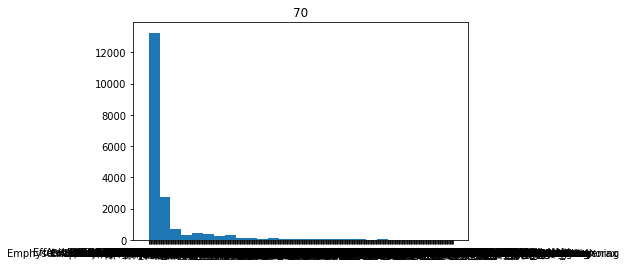

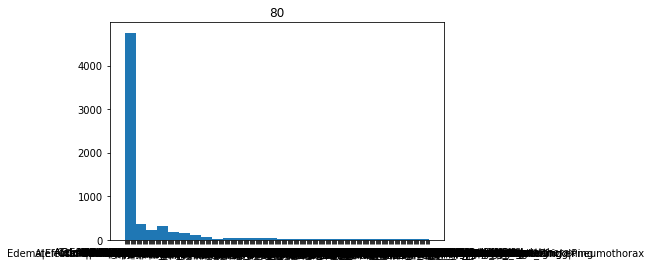

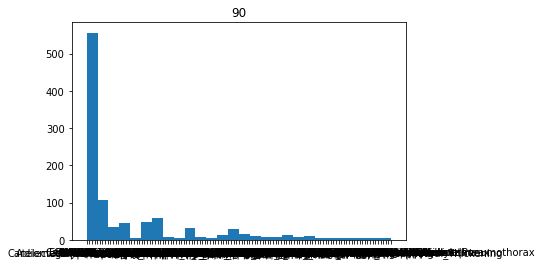

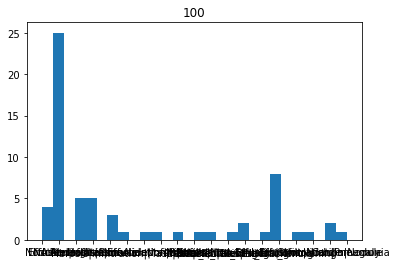

<Figure size 432x288 with 0 Axes>

In [ ]:
for i in rangos:
  plt.hist(df[(df['Patient Age']>=i-10) & (df['Patient Age']<i)]['Finding Labels'],28)
  plt.title(i)
  # Show and clean up plot
  plt.show()
  plt.clf()

# **8. Análisis género**

In [ ]:
df['Patient Gender'].describe()

count     112120
unique         2
top            M
freq       63340
Name: Patient Gender, dtype: object

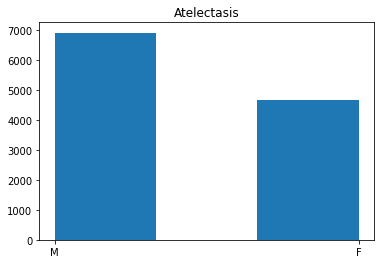

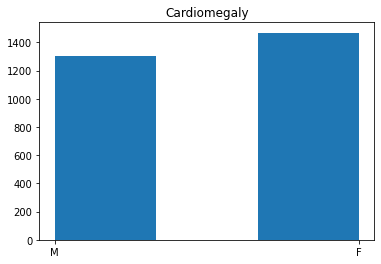

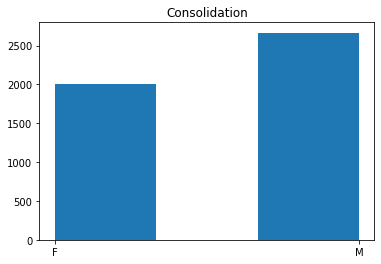

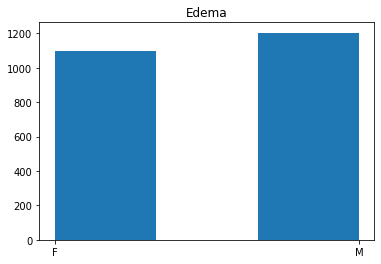

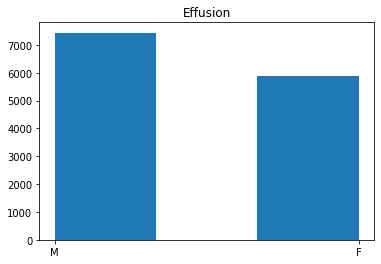

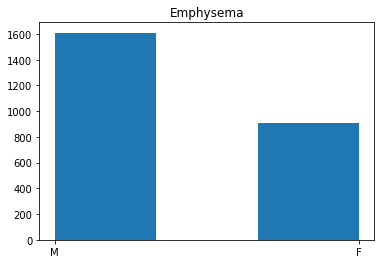

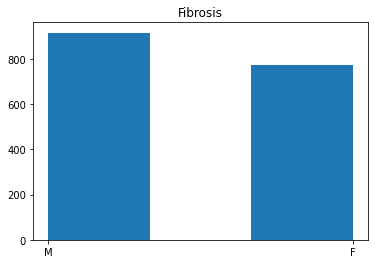

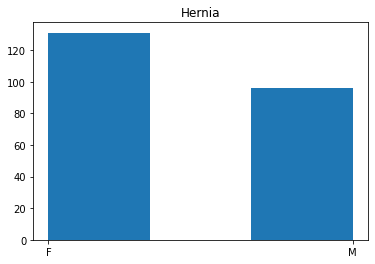

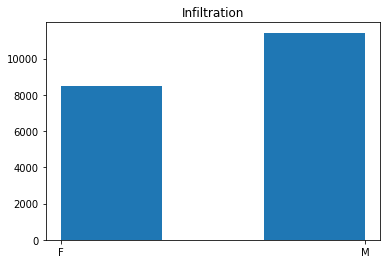

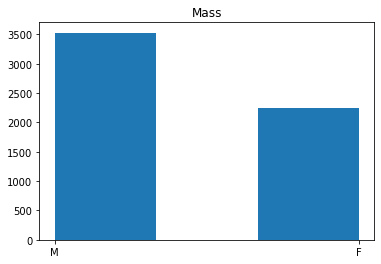

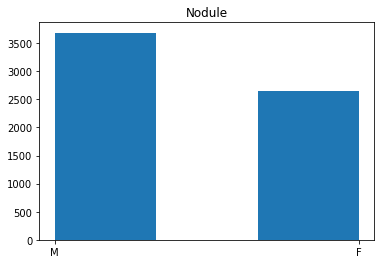

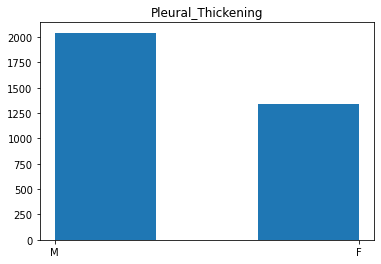

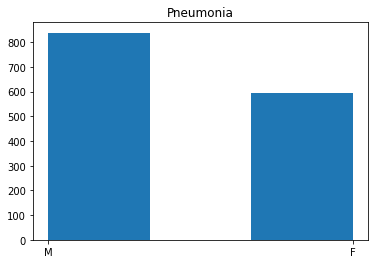

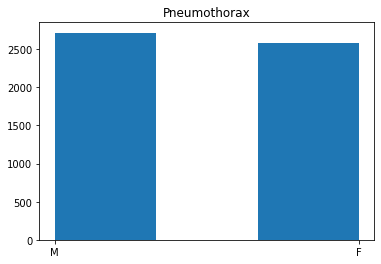

<Figure size 432x288 with 0 Axes>

In [ ]:
for name in class_names_list:
  plt.hist(df[df['Finding Labels'].str.contains(name)]['Patient Gender'], bins=3)
  plt.title(name)
  # Show and clean up plot
  plt.show()
  plt.clf()

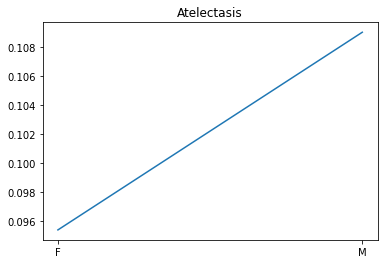

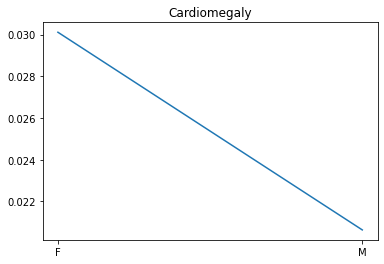

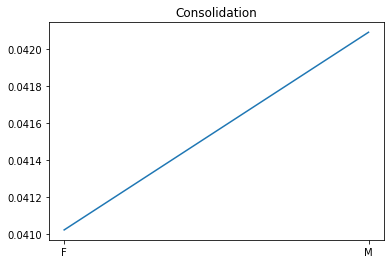

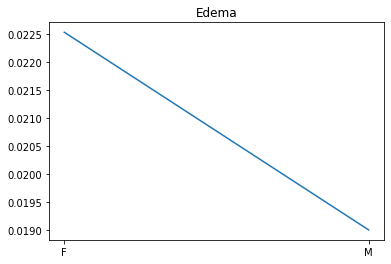

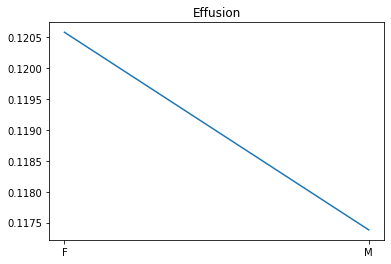

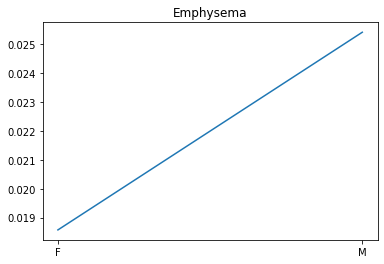

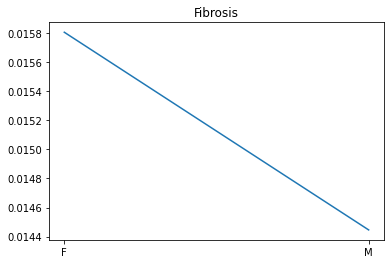

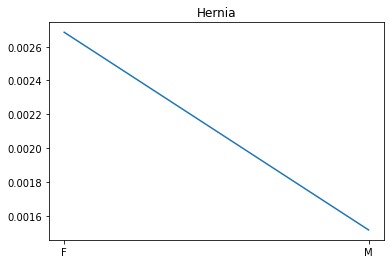

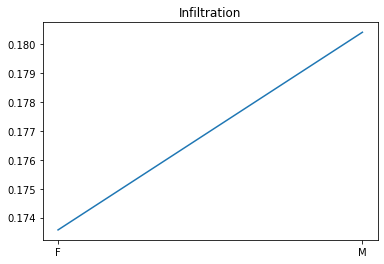

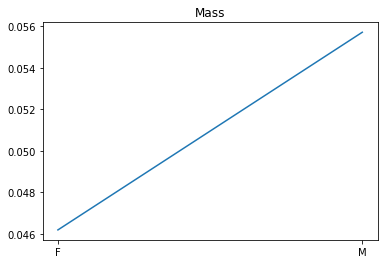

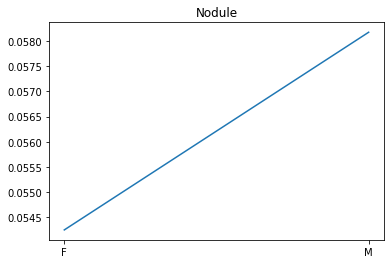

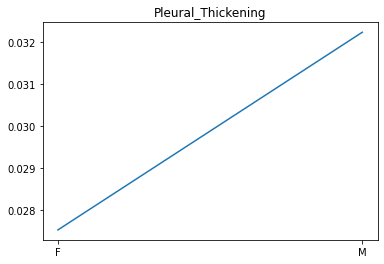

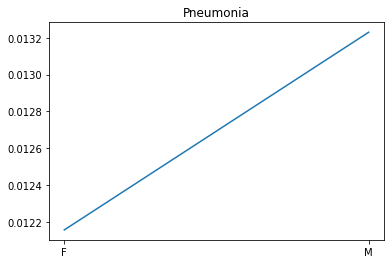

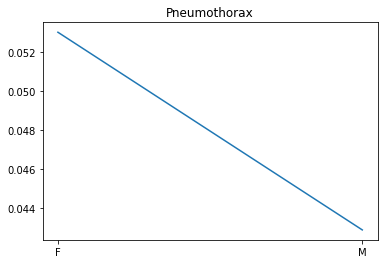

<Figure size 432x288 with 0 Axes>

In [ ]:
rangos = ['F','M']

for name in class_names_list:
  porcentajes_genero = []
  j = 0
  df_inf = df[df['Finding Labels'].str.contains(name)]
  
  for i in rangos:
    num_total = df[(df['Patient Gender']==i)].count()['Patient Gender']
    num_caso = df_inf[(df_inf['Patient Gender']==i)].count()['Patient Gender']
    
    porcentajes_genero.append(num_caso/num_total)
    j += 1
    
  plt.plot(rangos,porcentajes_genero)
  plt.title(name)
  # Show and clean up plot
  plt.show()
  plt.clf()


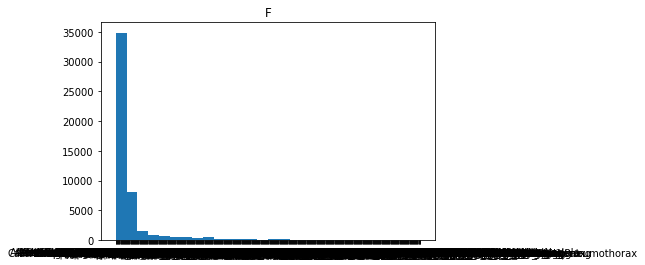

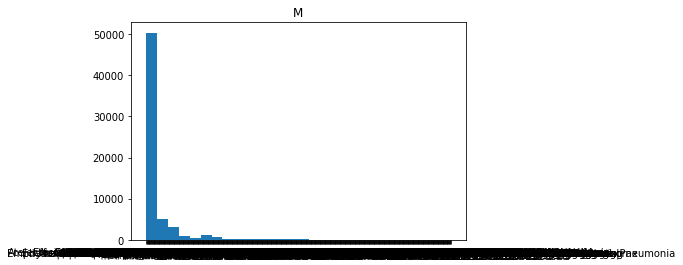

<Figure size 432x288 with 0 Axes>

In [ ]:
for i in rangos:
  plt.hist(df[df['Patient Gender']==i]['Finding Labels'],28)
  plt.title(i)
  # Show and clean up plot
  plt.show()
  plt.clf()



# **9. Correlación**

In [ ]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

df_c = df

rangos_edad = [25, 50, 75, 100]

for label in class_names_list:
    df_c[label] = df_c['Finding Labels'].map(lambda result: 1.0 if label in result else 0)
for label in ['F','M']:
    df_c[label] = df_c['Patient Gender'].map(lambda result: 1.0 if 'F'==result else 0)
for edad in rangos_edad:
    df_c[str(edad)] = df_c['Patient Age'].map(lambda result: 1.0 if (edad<result and edad>=result-25) else 0)

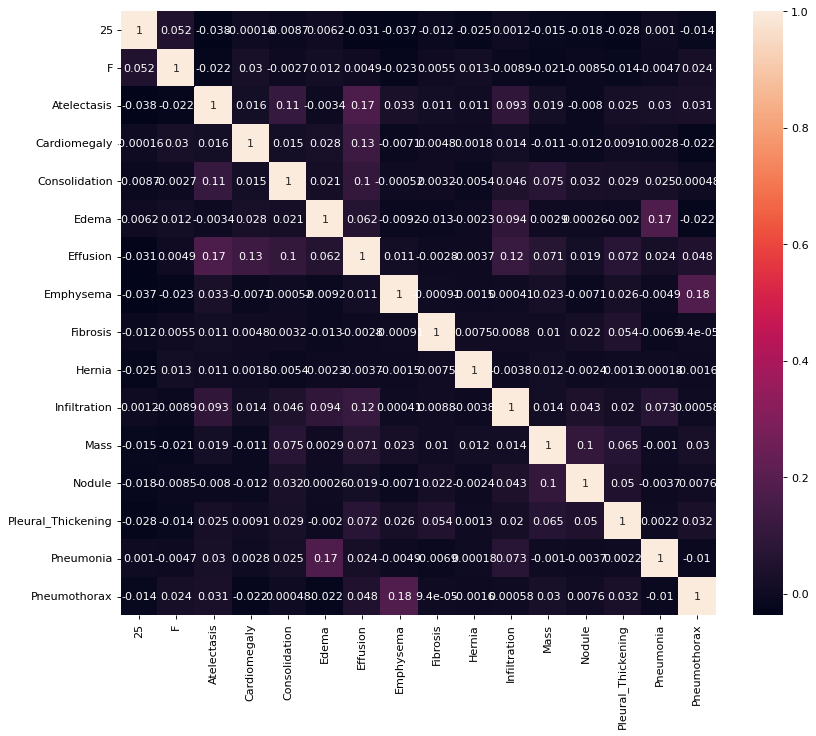

In [ ]:
figure(figsize=(12, 10), dpi=80)

df_co = df_c[['25','F','Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']]

corrMatrix = df_co.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

In [ ]:
corrMatrix

,25,F,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
25,1.000000,0.051976,-0.037624,-0.000160,-0.008670,0.006171,-0.030914,-0.037100,-0.011800,-0.025391,0.001152,-0.014591,-0.017652,-0.027738,0.001004,-0.013537
F,0.051976,1.000000,-0.022243,0.030246,-0.002654,0.012307,0.004903,-0.022913,0.005539,0.012903,-0.008866,-0.021359,-0.008451,-0.013637,-0.004742,0.023585
Atelectasis,-0.037624,-0.022243,1.000000,0.015819,0.108943,-0.003397,0.172445,0.032599,0.011130,0.010830,0.093131,0.018953,-0.007967,0.025202,0.029911,0.031422
Cardiomegaly,-0.000160,0.030246,0.015819,1.000000,0.015360,0.028318,0.130094,-0.007090,0.004837,0.001762,0.014189,-0.010682,-0.012123,0.009121,0.002848,-0.022248
Consolidation,-0.008670,-0.002654,0.108943,0.015360,1.000000,0.020822,0.101130,-0.000521,0.003236,-0.005413,0.045926,0.074573,0.031819,0.028733,0.025235,0.000485
Edema,0.006171,0.012307,-0.003397,0.028318,0.020822,1.000000,0.062092,-0.009204,-0.013243,-0.002326,0.094208,0.002910,0.000261,-0.002032,0.173996,-0.022487
Effusion,-0.030914,0.004903,0.172445,0.130094,0.101130,0.062092,1.000000,0.011198,-0.002776,-0.003656,0.118136,0.070710,0.019114,0.072009,0.024322,0.047571
Emphysema,-0.037100,-0.022913,0.032599,-0.007090,-0.000521,-0.009204,0.011198,1.000000,-0.000908,-0.001466,0.000406,0.023213,-0.007062,0.026408,-0.004888,0.178175
Fibrosis,-0.011800,0.005539,0.011130,0.004837,0.003236,-0.013243,-0.002776,-0.000908,1.000000,0.007478,0.008794,0.009959,0.022478,0.053578,-0.006867,0.000094
Hernia,-0.025391,0.012903,0.010830,0.001762,-0.005413,-0.002326,-0.003656,-0.001466,0.007478,1.000000,-0.003780,0.011927,-0.002422,0.001330,0.000182,-0.001621


# 10. Posición

In [ ]:
df["View Position"].describe()

count     112120
unique         2
top           PA
freq       67310
Name: View Position, dtype: object

In [ ]:
print("Proportion of PA chest x-rays: ", len(df[df["View Position"] == "PA"]) / len(df))

Proportion of PA chest x-rays:  0.6003389225829469


In [ ]:
df['Healthy Indicator'] = np.where(
    df['Finding Labels'] == "No Finding", 1, 0)

In [ ]:
pd.crosstab(df['View Position'], 
                            df['Healthy Indicator'],
                                margins = False)

Healthy Indicator,0,1
View Position,,
AP,23751,21059
PA,28008,39302


In [ ]:
print("odds ratio: ", (21059*28008)/(23751*39302)) 

odds ratio:  0.6318635328583054


In [ ]:
from scipy import stats

data = [
    [23751, 21059], 
    [39302, 28008] 
]
chi2_statistic, p_value, dof, ex = stats.chi2_contingency(data)

print("Chi-squared: ", chi2_statistic)
print("p-value: ", p_value)

Chi-squared:  316.83596528203975
p-value:  7.081203196565722e-71
